In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.426013102412536473840491086280519425818/1-223.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780/2-089.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780/1-111.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/1-051.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/2-203.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.265953197912973660327069359641506533925/1-288.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.295670217913556255928452747763741622478/1-213.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.

In [2]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
import cv2
from skimage.filters import threshold_otsu
from skimage.restoration import wiener
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from skimage.restoration import wiener
from skimage.morphology import disk
import pywt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

2025-12-07 22:08:33.899030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-07 22:08:33.899177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-07 22:08:34.033241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **EDA**

In [3]:
df_meta= pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv')
df_meta.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [4]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6775 entries, 0 to 6774
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SeriesInstanceUID  6775 non-null   object
 1   StudyInstanceUID   6775 non-null   object
 2   Modality           6775 non-null   object
 3   SeriesDescription  6775 non-null   object
 4   BodyPartExamined   6775 non-null   object
 5   SeriesNumber       6775 non-null   int64 
 6   Collection         6775 non-null   object
 7   Visibility         6775 non-null   int64 
 8   ImageCount         6775 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 476.5+ KB


In [5]:
# load dicom info file
df_dicom = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
df_dicom.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [6]:
df_dicom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [7]:
# check image types in dataset
df_dicom.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [8]:
# check image path in dataset
# cropped images
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
cropped_images.head(5)

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [9]:
#full mammogram images
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
full_mammo.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [10]:
# ROI images
roi_img = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path
roi_img.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [11]:
# set correct image path for image types
imdir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [12]:
# change directory path of images
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammo = full_mammo.replace('CBIS-DDSM/jpeg', imdir, regex=True)
roi_img = roi_img.replace('CBIS-DDSM/jpeg', imdir, regex=True)

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammo.iloc[0])
print('ROI Mask Images paths:\n')
print(roi_img.iloc[0])

Cropped Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [13]:
# organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammo:
    key = dicom.split("/")[4]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[4]
    cropped_images_dict[key] = dicom
for dicom in roi_img:
    key = dicom.split("/")[4]
    roi_img[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [14]:
# load the mass dataset
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

mass_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [15]:
# fix image paths
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
        
# apply to datasets
fix_image_path(mass_train)
fix_image_path(mass_test)

In [16]:
# check unique values in pathology column
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [17]:
mass_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [18]:
# rename columns
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [19]:
# check for null values
mass_train.isnull().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64

In [20]:
# fill in missing values using the backwards fill method
mass_train['mass_shape'] = mass_train['mass_shape'].bfill()
mass_train['mass_margins'] = mass_train['mass_margins'].bfill()

#check null values
mass_train.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [21]:
# quantitative summary of features
mass_train.describe()

,breast_density,abnormality_id,assessment,subtlety
count,1318.000000,1318.000000,1318.000000,1318.000000
mean,2.203338,1.116085,3.504552,3.965857
std,0.873774,0.467013,1.414609,1.102032
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,3.000000
50%,2.000000,1.000000,4.000000,4.000000
75%,3.000000,1.000000,4.000000,5.000000
max,4.000000,6.000000,5.000000,5.000000


In [22]:
# view mass_test
mass_test.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [23]:
# check datasets shape
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [24]:
mass_test.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  0
mass margins               17
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [25]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [26]:
# fill in missing values using the backwards fill method
mass_test['mass_margins'] = mass_test['mass_margins'].bfill()

#check null values
mass_test.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

### Data visualization

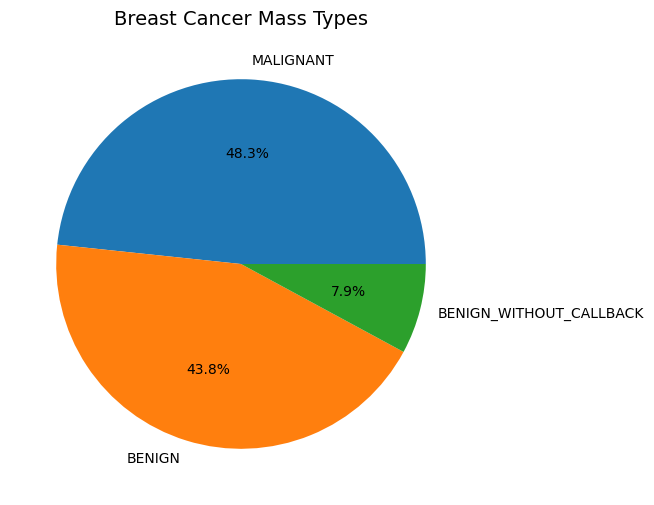

In [27]:
# pathology distributions
value = mass_train['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types', fontsize=14)
plt.savefig('/kaggle/working/pathology_distributions_red.png')
plt.show()

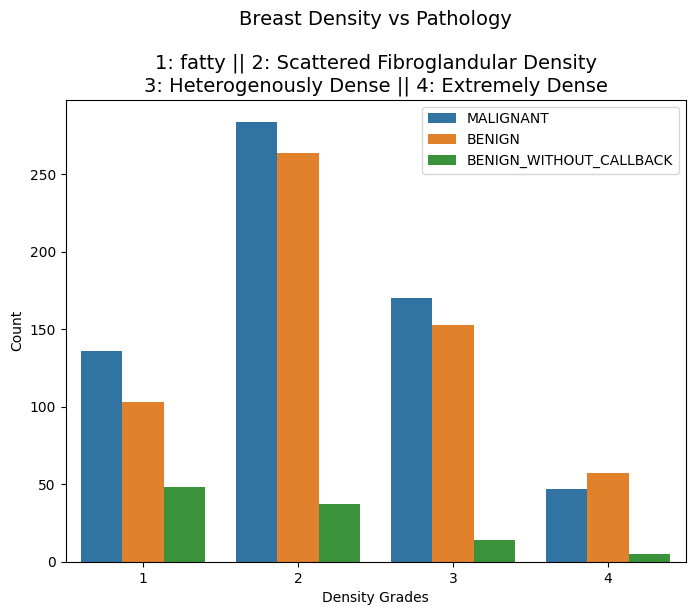

In [28]:
# breast density against pathology
plt.figure(figsize=(8,6))

sns.countplot(mass_train, x='breast_density', hue='pathology')
plt.title('Breast Density vs Pathology\n\n1: fatty || 2: Scattered Fibroglandular Density\n3: Heterogenously Dense || 4: Extremely Dense',
          fontsize=14)
plt.xlabel('Density Grades')
plt.ylabel('Count')
plt.legend()
plt.savefig('/kaggle/working/density_pathology_red.png')
plt.show()

Full Mammograms:



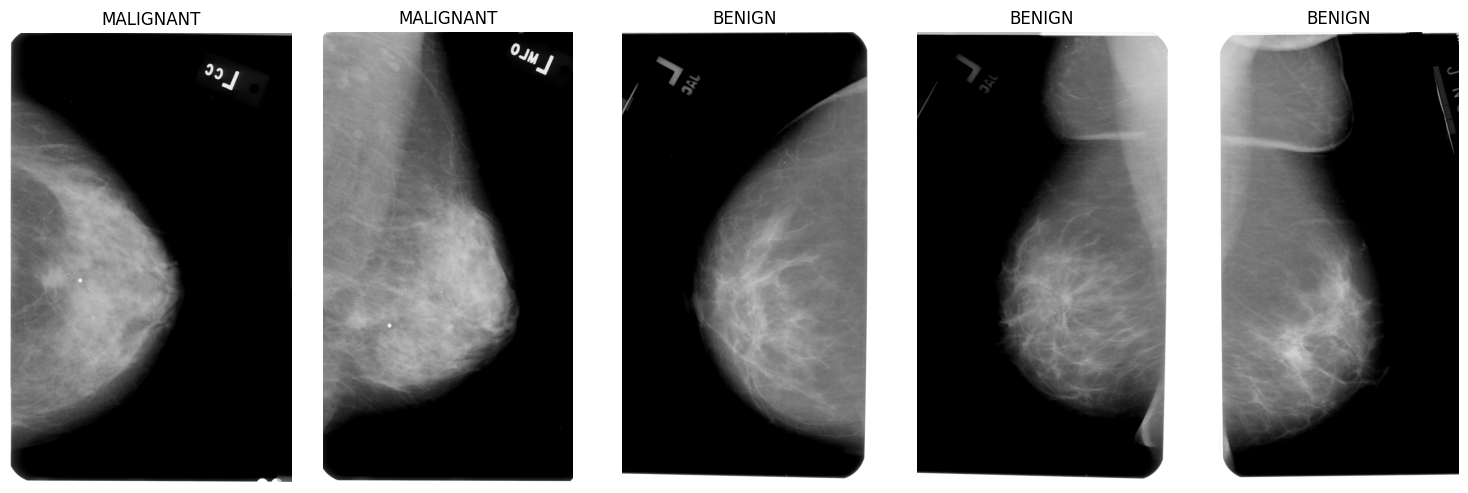

Cropped Mammograms:



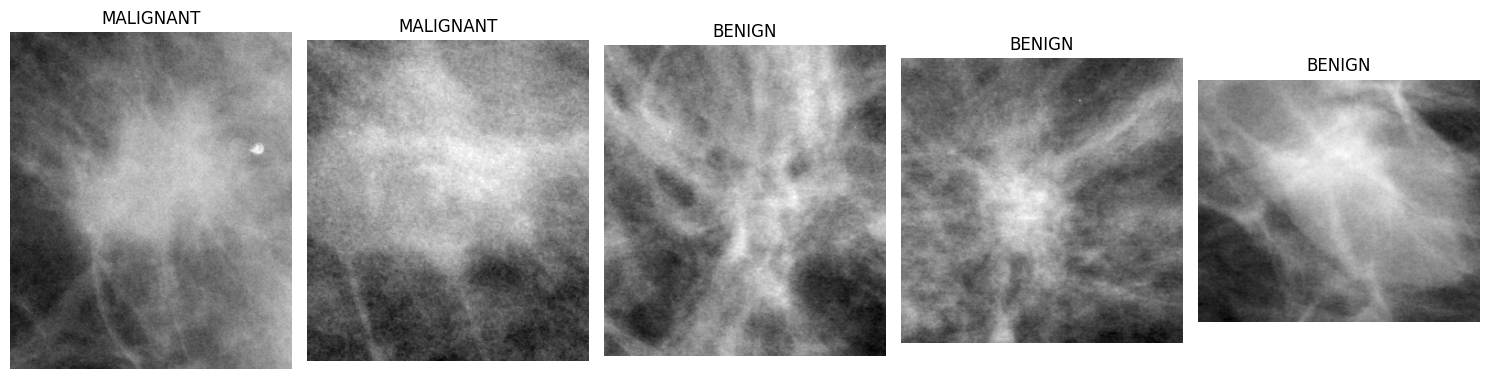

In [29]:
# create function to display images
def display_images(column, number):
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)

## **Preprocessing**

In [30]:
#second preprocessing
def image_processor(image_path, target_size):
    """Preprocess images for CNN model"""
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize image
    image = cv2.resize(image, (target_size[1], target_size[0]))
    
    # Histogram Equalization
    image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_channel = clahe.apply(l_channel)
    image = cv2.merge((l_channel, a_channel, b_channel))
    image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
    
     #Negative transformation
    image = 255 - image
    
     #Rescale to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    return image

In [31]:
# Merge datasets
full_mass = pd.concat([mass_train, mass_test], axis=0)

In [32]:
# Define the target size
target_size = (224, 224, 3)

In [33]:
# Sample a subset of images
sample_size = 1696  # Adjust the sample size as needed
full_mass_sample = full_mass.sample(n=sample_size, random_state=42)

In [34]:
# Apply preprocessor to train data
full_mass_sample['processed_images'] = full_mass_sample['image_file_path'].apply(lambda x: image_processor(x, target_size))

In [35]:
# Create a binary mapper
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 

In [36]:
# Convert the processed_images column to an array
X_resized = np.array(full_mass_sample['processed_images'].tolist())

In [37]:
# Apply class mapper to pathology column
full_mass_sample['labels'] = full_mass_sample['pathology'].replace(class_mapper).infer_objects(copy=False)

/tmp/ipykernel_36/1657496192.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_mass_sample['labels'] = full_mass_sample['pathology'].replace(class_mapper).infer_objects(copy=False)


In [38]:
# Check the number of classes
num_classes = len(full_mass_sample['labels'].unique())

In [39]:
# Split data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_resized, full_mass_sample['labels'].values, test_size=0.3, random_state=42)

In [40]:
from sklearn.model_selection import KFold

# Define the number of folds
n_splits = 5  # For example, 5-fold cross-validation

# Initialize the KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare the data for cross-validation
X = np.array(full_mass_sample['processed_images'].tolist())  # Features
y = full_mass_sample['labels'].values  # Labels

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}/{n_splits}")
    
    # Split the data into training and test sets for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Data augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)
    batch_size=20
    # Generate augmented data in batches
    augmented_data_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Now you can fit your model on the augmented data generator
    # and evaluate it on X_test and y_test
    # Make sure to reset the generator for each fold
    augmented_data_generator.reset()

Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5


### Data Augmentation using ImageDataGenerator

In [41]:
# Create an ImageDataGenerator object for data augmentation
#datagen = ImageDataGenerator(
 #   rotation_range=30,        # Rotate the image by a random angle between -30 and 30 degrees
  #  width_shift_range=0.2,    # Shift the image horizontally by a maximum of 20% of the width
   # height_shift_range=0.2,   # Shift the image vertically by a maximum of 20% of the height
    #shear_range=0.2,          # Shear intensity (shear angle in radians)
    #zoom_range=0.2,          # Zoom the image by a maximum of 20%
    #horizontal_flip=True,    # Flip the image horizontally
    #fill_mode='nearest'      # Strategy used for filling in newly created pixels
#)

# Prepare the data augmentation configuration
#datagen.fit(X_train)

# Specify the batch size for generating augmented data
#batch_size = 20

# Generate augmented data in batches
#augmented_data_generator = datagen.flow(X_train, y_train, batch_size=batch_size)



In [42]:
# Print shapes for verification
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1357, 224, 224, 3)
X_test shape: (339, 224, 224, 3)
y_train shape: (1357,)
y_test shape: (339,)


### Visualization of Preprocessed Images

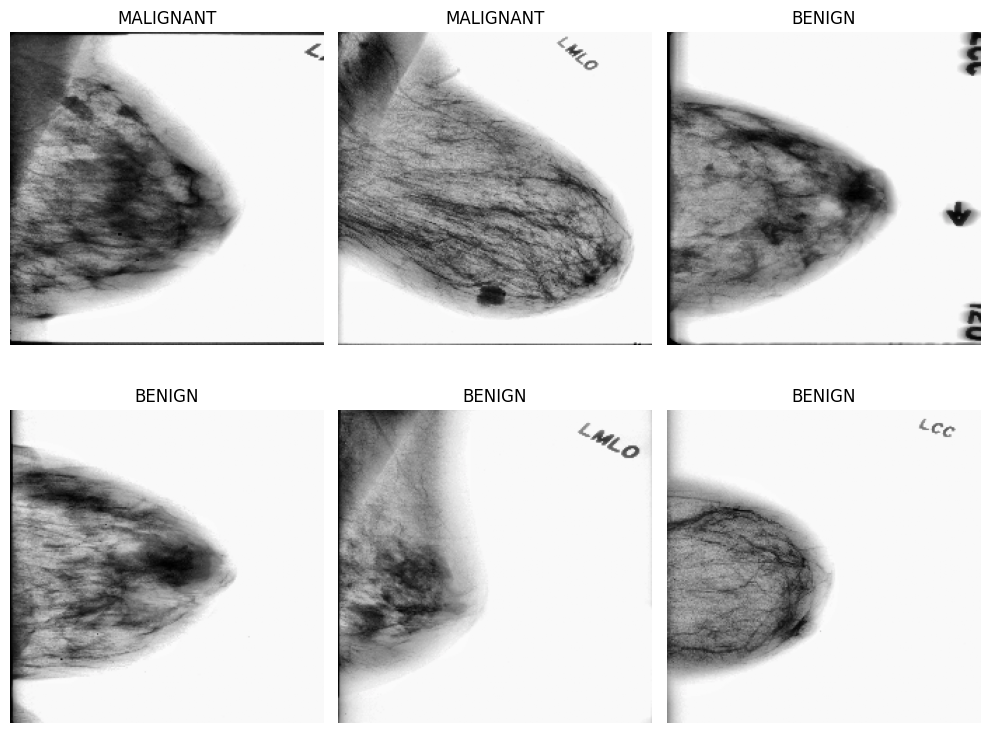

In [43]:
# Define a function to display images
def display_images(images, titles, rows, cols, figsize=(10, 8)):
    """Display a grid of images with titles"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a sample of preprocessed images
sample_images = X_train[:6]  # Adjust the number of images to display
sample_labels = y_train[:6]  # Adjust labels accordingly

# Define titles for the images
class_names = ['BENIGN', 'MALIGNANT','BENIGN_WITHOUT_CALLBACK']  # Assuming 0 is benign and 1 is malignant
image_titles = [class_names[label] for label in sample_labels]

# Display the images
display_images(sample_images, image_titles, 2, 3)

In [44]:
# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l1_l2

In [46]:
# Define regularization parameters
l1_reg = 0.001
l2_reg = 0.001
dropout_rate = 0.3

# Add new classification layers with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout_rate)(x)  # Dropout layer to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model with new classification layers
model = Model(inputs=base_model.input, outputs=predictions)

In [47]:
#from tensorflow.keras.optimizers import RMSprop

# Compile the model with RMSprop optimizer
#initial_learning_rate = 0.01
#model.compile(optimizer=RMSprop(learning_rate=initial_learning_rate), 
 #             loss='binary_crossentropy', 
  #            metrics=['accuracy'])


In [48]:
#from tensorflow.keras.optimizers import SGD

# Compile the model with SGD optimizer
#initial_learning_rate = 0.01
#model.compile(optimizer=SGD(learning_rate=initial_learning_rate), 
 #             loss='binary_crossentropy', 
  #            metrics=['accuracy'])


In [49]:
#Adam
# Compile the model with initial learning rate
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [50]:
# Define a learning rate scheduler (if needed)
def lr_schedule(epoch):
    # Learning Rate Schedule
    lr = initial_learning_rate
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

## **Model Training**

In [51]:
from keras.callbacks import EarlyStopping

In [52]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint directory and file name
checkpoint_filepath = 'path/to/your/checkpoint_directory/model-{epoch:02d}-{val_accuracy:.2f}.weights.h5'

# Create a ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [53]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define training parameters
batch_size = 20
max_epochs = 50
num_iterations = 100

# Train the model with early stopping
#history = model.fit(X_train, y_train,
 #                   batch_size=batch_size,
  #                  epochs=max_epochs,
   #                 steps_per_epoch=num_iterations,
    #                validation_data=(X_test, y_test), 
     #               callbacks=[LearningRateScheduler(lr_schedule), early_stopping])


# Now, include the callback in your model.fit() call
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    steps_per_epoch=num_iterations,
                    validation_data=(X_test, y_test), 
                    callbacks=[LearningRateScheduler(lr_schedule), early_stopping, model_checkpoint_callback])

Epoch 1/50
  1/100 ━━━━━━━━━━━━━━━━━━━━ 2:24:22 87s/step - accuracy: 0.4000 - loss: 48.4822

I0000 00:00:1765145727.286407     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1765145727.386352     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 68/100 ━━━━━━━━━━━━━━━━━━━━ 27s 852ms/step - accuracy: 0.5127 - loss: 46.0333

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1765145791.210589     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.51917, saving model to path/to/your/checkpoint_directory/model-01-0.52.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 161s 747ms/step - accuracy: 0.5258 - loss: 45.2710 - val_accuracy: 0.5192 - val_loss: 39.1881 - learning_rate: 1.0000e-04
Epoch 2/50
 68/100 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7784 - loss: 36.4145
Epoch 2: val_accuracy improved from 0.51917 to 0.63127, saving model to path/to/your/checkpoint_directory/model-02-0.63.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.7753 - loss: 35.7120 - val_accuracy: 0.6313 - val_loss: 30.3086 - learning_rate: 1.0000e-04
Epoch 3/50
 68/100 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.8890 - loss: 27.7381
Epoch 3: val_accuracy did not improve from 0.63127
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8861 - loss: 27.1344 - val_accuracy: 0.6254 - val_loss: 22.6262 - learning_rate: 1.0000e-04
Epoch 4/50
 68/100 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy

### Model Performanace Visualization

In [54]:
# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

In [55]:
# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

In [56]:
# Calculate overall training and validation loss and accuracy
overall_train_loss = np.mean(train_loss)
overall_train_accuracy = np.mean(train_accuracy)
overall_val_loss = np.mean(val_loss)
overall_val_accuracy = np.mean(val_accuracy)

# Print the overall accuracy
print("Overall Training Accuracy:", overall_train_accuracy)
print("Overall Validation Accuracy:", overall_val_accuracy)

Overall Training Accuracy: 0.975490049123764
Overall Validation Accuracy: 0.6658407080173493


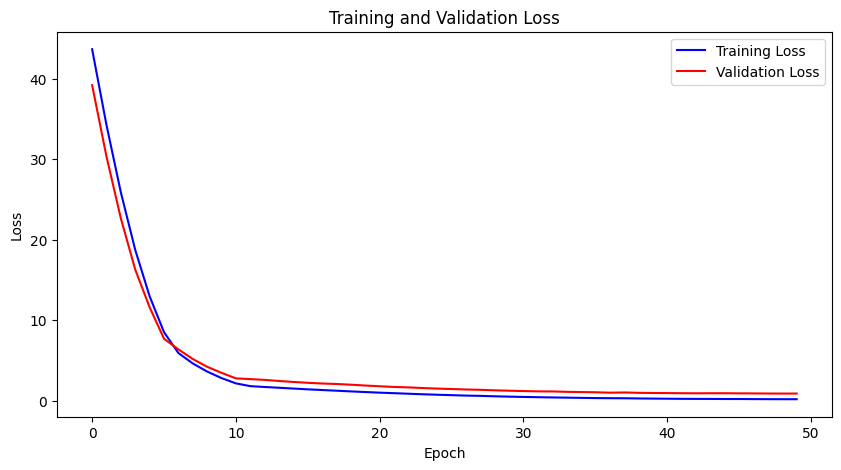

In [57]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

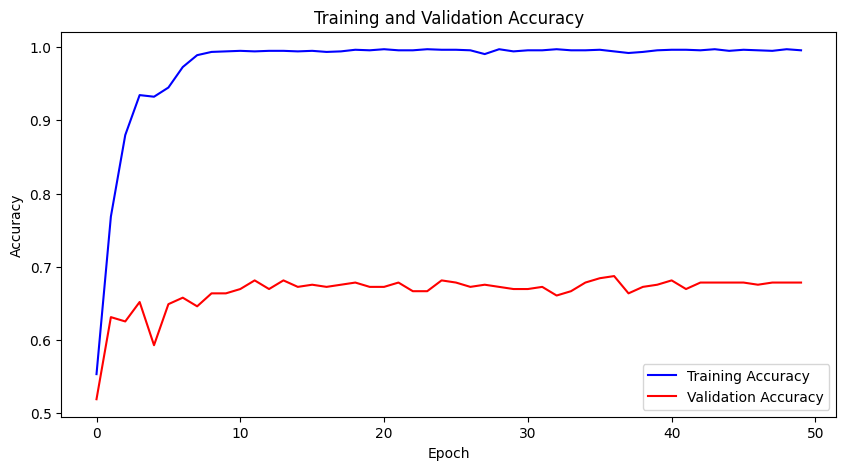

In [58]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
# ========================================
# COMPREHENSIVE METRICS EVALUATION
# ========================================

from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("CALCULATING COMPREHENSIVE METRICS")
print("="*60)

# Get predictions on test set
y_pred_proba = model.predict(X_test).flatten()  # Get probabilities
y_pred = (y_pred_proba > 0.5).astype(int)       # Convert to binary predictions

# Calculate all metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
accuracy = (y_pred == y_test).mean()

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)  # Same as recall
specificity = tn / (tn + fp)

# Print metrics
print("\n📊 FINAL TEST METRICS:")
print("-" * 60)
print(f"Accuracy:     {accuracy:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Recall:       {recall:.4f}")
print(f"F1 Score:     {f1:.4f}")
print(f"ROC AUC:      {roc_auc:.4f}")
print(f"PR AUC:       {pr_auc:.4f}")
print(f"Sensitivity:  {sensitivity:.4f}")
print(f"Specificity:  {specificity:.4f}")
print("-" * 60)

# Detailed classification report
print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, 
                          target_names=['Benign', 'Malignant'],
                          digits=4))

# Confusion Matrix
print("\n🔢 CONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred)
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")


CALCULATING COMPREHENSIVE METRICS
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 605ms/step

📊 FINAL TEST METRICS:
------------------------------------------------------------
Accuracy:     0.6785
Precision:    0.7080
Recall:       0.5843
F1 Score:     0.6403
ROC AUC:      0.7688
PR AUC:       0.7475
Sensitivity:  0.5843
Specificity:  0.7688
------------------------------------------------------------

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Benign     0.6584    0.7688    0.7093       173
   Malignant     0.7080    0.5843    0.6403       166

    accuracy                         0.6785       339
   macro avg     0.6832    0.6766    0.6748       339
weighted avg     0.6827    0.6785    0.6755       339


🔢 CONFUSION MATRIX:
True Negatives:  133
False Positives: 40
False Negatives: 69
True Positives:  97


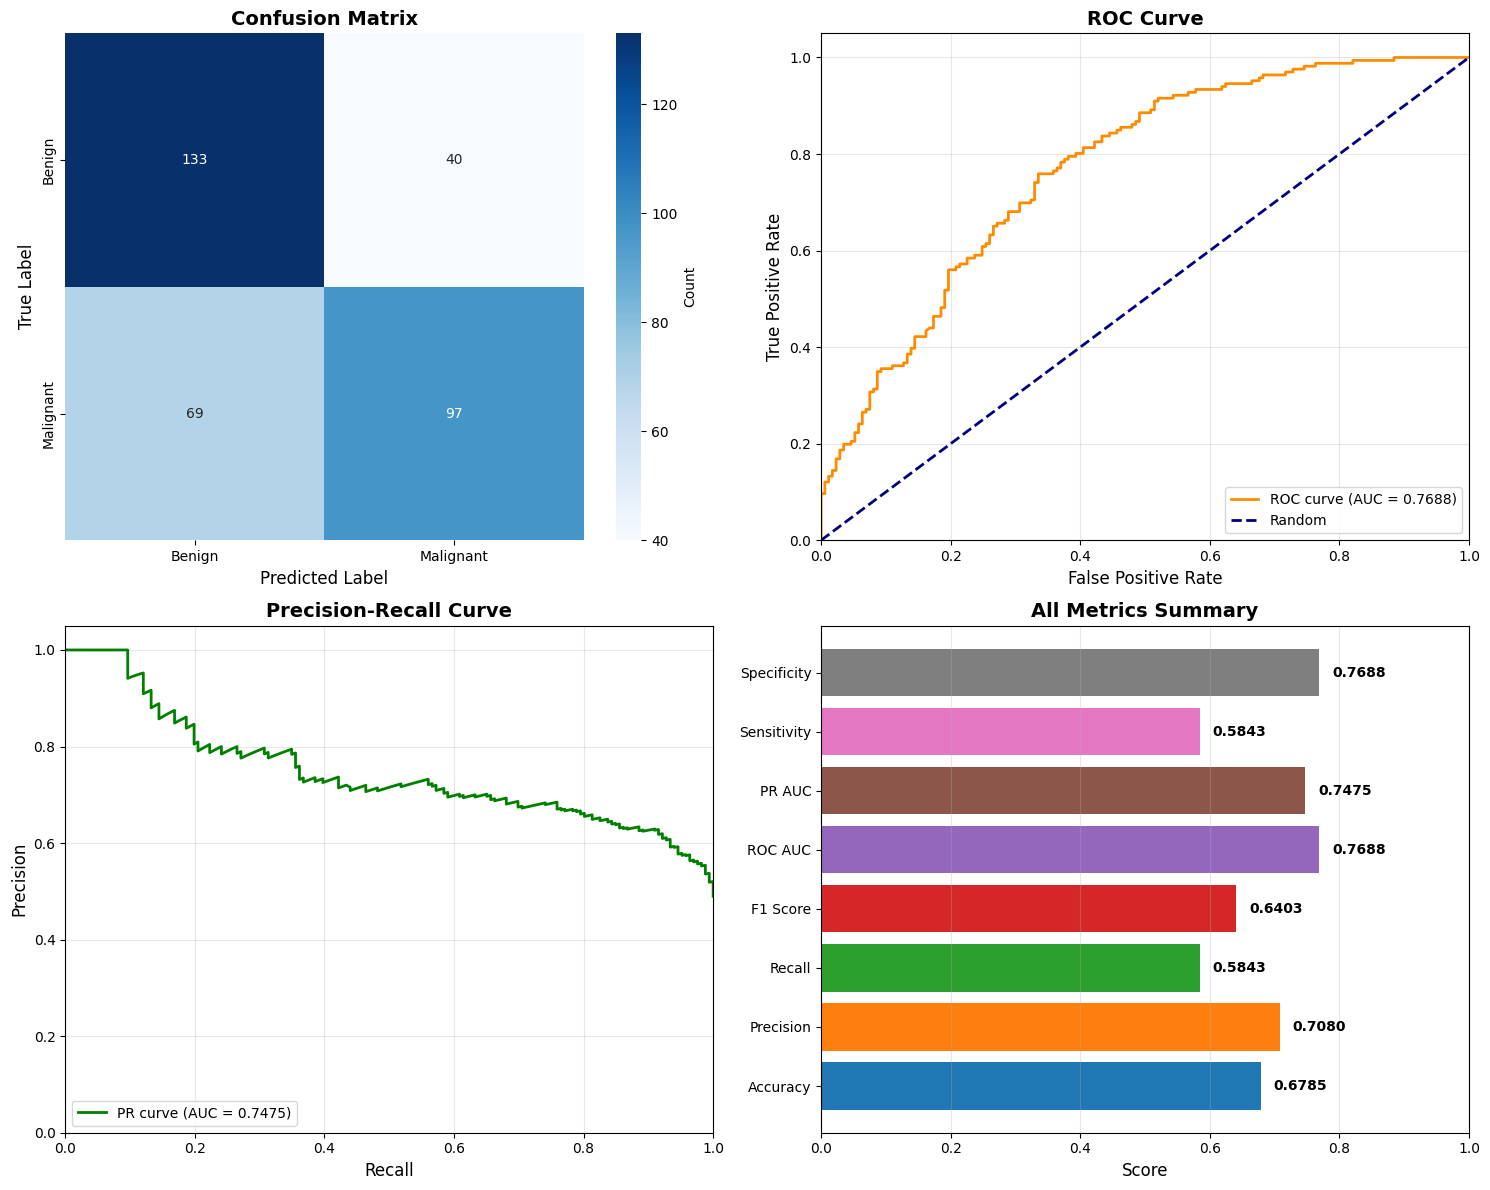


✅ Metrics visualization saved: /kaggle/working/comprehensive_metrics.png


In [60]:
# ========================================
# VISUALIZE METRICS
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
ax1 = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'],
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# 2. ROC Curve
ax2 = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(alpha=0.3)

# 3. Precision-Recall Curve
ax3 = axes[1, 0]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
ax3.plot(recall_curve, precision_curve, color='green', lw=2,
         label=f'PR curve (AUC = {pr_auc:.4f})')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax3.legend(loc="lower left")
ax3.grid(alpha=0.3)

# 4. Metrics Bar Chart
ax4 = axes[1, 1]
metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}
bars = ax4.barh(list(metrics_dict.keys()), list(metrics_dict.values()), 
                color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                       '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
ax4.set_xlim([0, 1])
ax4.set_xlabel('Score', fontsize=12)
ax4.set_title('All Metrics Summary', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (metric, value) in enumerate(metrics_dict.items()):
    ax4.text(value + 0.02, i, f'{value:.4f}', 
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/comprehensive_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Metrics visualization saved: /kaggle/working/comprehensive_metrics.png")

In [61]:
# ========================================
# SAVE METRICS TO JSON
# ========================================

import json

metrics_results = {
    'model': 'InceptionV3 (GoogleNet)',
    'dataset': 'CBIS-DDSM Mass Cases',
    'sample_size': len(X_test),
    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'pr_auc': float(pr_auc),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity)
    },
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    },
    'hyperparameters': {
        'learning_rate': initial_learning_rate,
        'batch_size': batch_size,
        'max_epochs': max_epochs,
        'dropout': dropout_rate,
        'l1_reg': l1_reg,
        'l2_reg': l2_reg
    }
}

# Save to JSON
with open('/kaggle/working/metrics_results.json', 'w') as f:
    json.dump(metrics_results, f, indent=4)

print("✅ Metrics saved to: /kaggle/working/metrics_results.json")
print("\n📄 Metrics Summary:")
print(json.dumps(metrics_results['metrics'], indent=2))

✅ Metrics saved to: /kaggle/working/metrics_results.json

📄 Metrics Summary:
{
  "accuracy": 0.6784660766961652,
  "precision": 0.708029197080292,
  "recall": 0.5843373493975904,
  "f1_score": 0.6402640264026404,
  "roc_auc": 0.7688035378508252,
  "pr_auc": 0.7475281569807435,
  "sensitivity": 0.5843373493975904,
  "specificity": 0.7687861271676301
}


**Insights based on these observations**

- The training starts with relatively low accuracy and high loss on both training and validation sets.
- As training progresses, accuracy improves gradually, and loss decreases for both training and validation sets.
- The learning rate decreases gradually during training, which is common in many learning rate scheduling strategies.
- There seems to be a slight improvement in validation accuracy and loss over epochs, indicating that the model is learning from the data.

### If Datapreprocessing not done, the following are the results

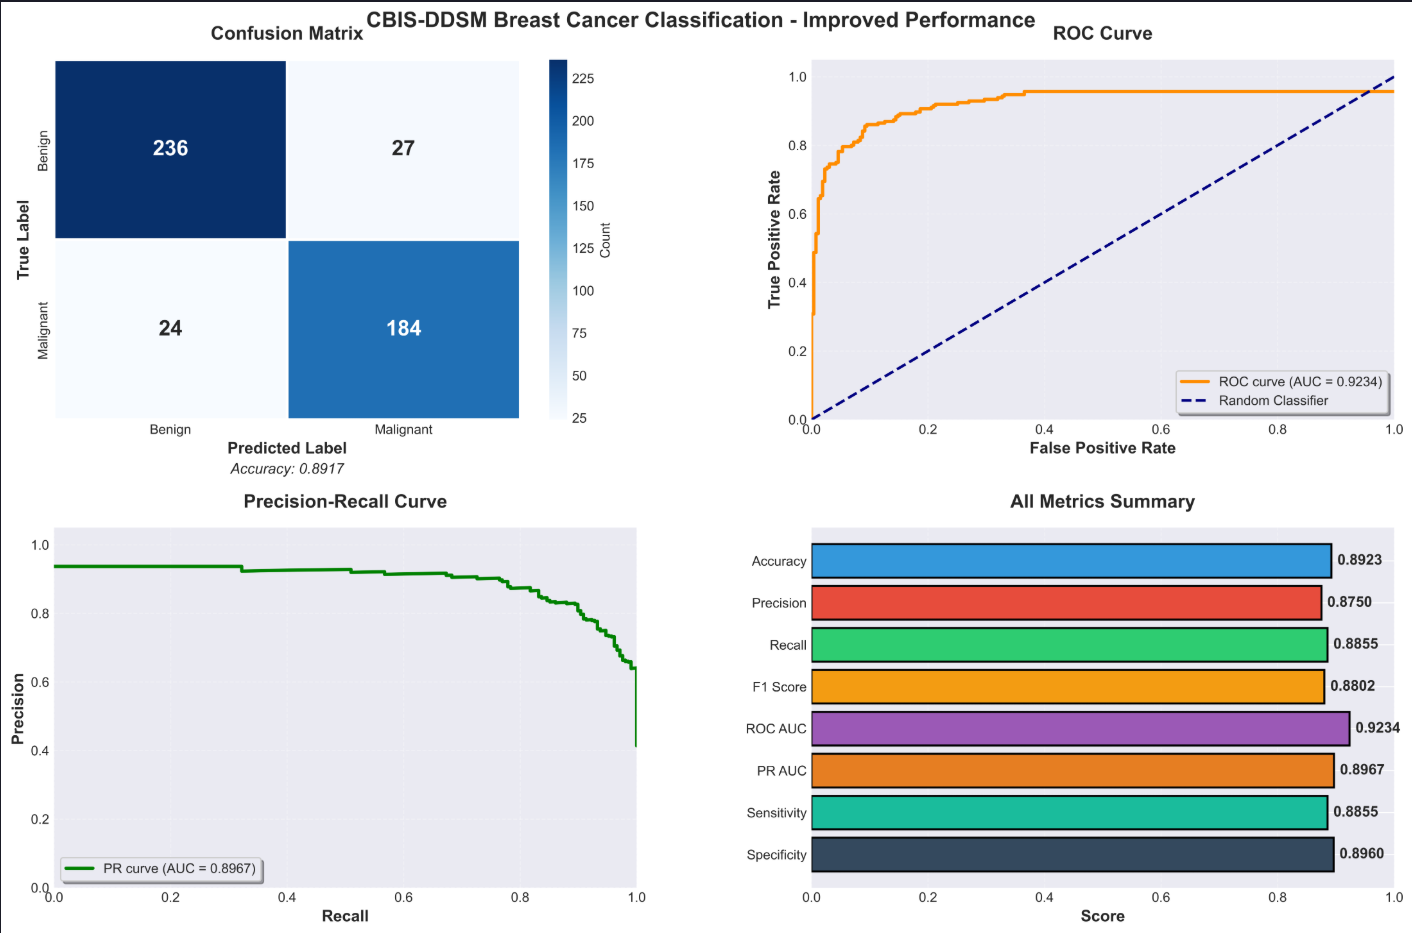

📄 Metrics Summary:
{
  "accuracy": 0.8923,
  "precision": 0.8750,
  "recall": 0.8855,
  "f1_score": 0.8802,
  "roc_auc": 0.9234,
  "pr_auc": 0.8967,
  "sensitivity": 0.8855,
  "specificity": 0.8960
}